<a href="https://colab.research.google.com/github/Alecia113/NLP-Emotional-analysis/blob/main/A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [345]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1lTD6bgRkmwguGAr30v-r0KBPdtnVneLb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.pkl')  

id = '1pCUdlZMoj99UZHtqFeza86fvVQfFmDFX'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.pkl')  

import pickle #必要的
training_data = pickle.load(open("training_data.pkl","rb")) #必要的
testing_data = pickle.load(open("testing_data.pkl","rb")) #必要的

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data))) #8000
print("Size of testing dataset: {0}".format(len(testing_data))) #2000
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data[0][0], training_data[0][1]))
print("------------------------------------")
#LABEL: neg / SENTENCE: hopeless for tmr :(

------------------------------------
Size of training dataset: 8000
Size of testing dataset: 2000
------------------------------------
------------------------------------
Sample Data
LABEL: neg / SENTENCE: hopeless for tmr :(
------------------------------------


In [346]:
import torch
#You can enable GPU here (cuda); or just CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#分集合

train_data = [training_data[i][1] for i in range(len(training_data))]
train_label = [training_data[i][0] for i in range(len(training_data))]

test_data = [testing_data[i][1] for i in range(len(testing_data))]  
test_label = [testing_data[i][0] for i in range(len(testing_data))] #neg pos

#做预处理 变小写
import pprint
text_train = [s.lower() for s in train_data]
text_test = [s.lower() for s in test_data]

# 分词
import pprint
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()


train_t=[]  #完全每句话的分词的集合。train_t[0][0]每个单词
for s in text_train:
  text_train = tknzr.tokenize(s)                         #每句话分别作了分词 text_train[0]第一句话的分词
  train_t.append(text_train)  
        #:(    :-(


test_t=[]     #2000
for w in text_test:
  text_test = tknzr.tokenize(w)
  test_t.append(text_test)

#删
#theprincesszooz but i see what youre going at   
#yes  subjective pain may not be real
#  but that does not make it less painful

import re
def remove(x):
  t = []
  for i in range(len(x)):
    t_sub = []        #是直接用空列表代替了
    for j in range(len(x[i])):
      if len(x[i][j])==0:
        continue
      if x[i][j] == " ":
        continue 
      else:
        x[i][j] = re.sub(r'\d','',x[i][j])                  #删除0-9
        if len(x[i][j]) == 1 or len(x[i][j]) > 3:           #and + or 问题。
          x[i][j] = re.sub(r'[^\w\s+]','', x[i][j])
        if len(x[i][j]) == 0:
          continue 
        else:
          t_sub.append(x[i][j]) 
    t.append(t_sub) 

  return t

text_train = remove(train_t)
text_test = remove(test_t)

##停用词  
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stop_words = sw.words()
sww = sw.words()

text_train_le=[]    #8000
for tokens in text_train:
    filtered_sentence1 = [w for w in tokens if not w in stop_words]
    text_train_le.append(filtered_sentence1)


text_test_le=[]   #2000
for tokens in text_test:
  filtered_sentence2 = [w for w in tokens if not w in stop_words]
  text_test_le.append(filtered_sentence2)

#去掉复数 stemmer 词根不需要这部； 如果用就需要在neg和pos需要stemmer操作

from nltk.stem.porter import *
stemmer = PorterStemmer()
#text_train_le = [text_train_le[i] for i in range(len(text_train_le))]
#singles = [stemmer.stem(plural) for plural in text_train_le[i] for i in range(len(text_train_le))]
train_stem = []
for i in range(len(text_train_le)):
  singles1 = []
  for plural in text_train_le[i]:
    singles1.append(stemmer.stem(plural))
  train_stem.append(singles1)

#print(train_stem[:5])

test_stem = []
for i in range(len(text_test_le)):
  singles2 = []
  for plural in text_test_le[i]:
    singles2.append(stemmer.stem(plural))
  test_stem.append(singles2)

#print(test_stem[:5])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


W@B


In [347]:
from gensim.models import Word2Vec
wv_cbow_model = Word2Vec(sentences= train_stem + test_stem, size=100, window=5, min_count=2, workers=2, sg=0)


In [348]:
#看看单词
vocab = list(set(wv_cbow_model.wv.vocab.keys()))
print('vocabulary:', len(vocab), vocab[:5])

vocabulary: 4327 ['relationship', 'school', 'nathan', 'gayl', 'laomma']


In [349]:
#找出某个词向量最相近的词集合。
req_count = 100
for key in wv_cbow_model.wv.similar_by_word('school', topn =100):   #'school'.decode("ISO-8859-1")
    if len(key[0])==5:  #最相近的五个字的词
        req_count -= 1
        print(key[0], key[1])
        if req_count == 0:
            break;

wanna 0.9998646378517151
still 0.9998645782470703
peopl 0.9998570084571838
right 0.9998547434806824
video 0.9998529553413391
watch 0.9998511672019958
first 0.9998486042022705
thing 0.9998421669006348
didnt 0.9998396635055542
think 0.9998394846916199
never 0.9998376369476318
could 0.9998362064361572
littl 0.999830424785614
close 0.9998286366462708
start 0.9998242259025574
anoth 0.9998214244842529
gonna 0.9998192191123962
alway 0.9998166561126709
night 0.9998152852058411
music 0.999813973903656


In [350]:
#查看相似度。看两个词的相似度
print(wv_cbow_model.wv.similarity('thing', 'hope'))
print(wv_cbow_model.wv.similarity('phone', 'sleep'))
#https://blog.csdn.net/qq_35273499/article/details/79098689?ops_request_misc=&request_id=&biz_id=102&utm_term=gensim%20word2vec%20结果是什么&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-0-79098689.first_rank_v2_pc_rank_v29



0.9998787
0.9995533


In [351]:
#wv_cbow_model.wv.save_word2vec_format('ted_cbow_w2v.txt', binary=False)

In [ ]:
#训练
wv_cbow_model.save("cbow.model")
#训练 ； 存 取；训练。
cbow = Word2Vec.load("./cbow.model")
#再训练epochs训练多少epoch ##end_alpha ==learning rate final;   total_examples : count of sentences.10000
ep = 0
for i in range(10):
  cbow.train(sentences= train_stem + test_stem ,total_examples=wv_cbow_model.corpus_count, epochs=cbow.iter, compute_loss=True)
  #举个例子，已经训练好的word2vec词表有[“我”,“爱”,“你”]三个词，给定一个新语料[“我”,“喜”,“欢”,“你”]，新语料只会调整原有词中的“我”“你”的词向量表示，而不会将“喜”“欢”添加到词库中。
  ep += cbow.epochs
  print('Epoch: %d, train loss: %.5f'%(ep, cbow.get_latest_training_loss()))

In [353]:
#否定词"ISO-8859-1"==UTF-8
from google.colab import drive
drive.mount('/content/drive') #必须要挂载
not_words = [w.strip() for w in open('/content/drive/MyDrive/NLP/A1/E/opinion-lexicon-English/negative-words.txt', 'r', encoding="ISO-8859-1").readlines()]
#处理文件
j = -1
for i in not_words:
  j +=1
  if i == '2-faced':
    break
neg = not_words[j:]

#处理文件
sure_words = [w.strip() for w in open('/content/drive/MyDrive/NLP/A1/E/opinion-lexicon-English/positive-words.txt', 'r', encoding="ISO-8859-1").readlines()]

j = -1
for i in sure_words:
  j +=1
  if i == 'a+':
    break

pos = sure_words[j:]

#neg pos 词表
#要对他们做stem因为训练集做了stem


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [354]:
#也要对他做stem #太久了。简直了 至少10-20分钟，太久了。
neg_stem = []
for i in range(len(neg)):
  singles3 = []
  for plural in neg:
    singles3.append(stemmer.stem(plural))
  neg_stem.append(singles3)

print(neg_stem[:5])


pos_stem = []
for i in range(len(pos)):
  singles4 = []
  for plural in pos:
    singles4.append(stemmer.stem(plural))
  pos_stem.append(singles4)

print(pos_stem[:5])



[['2-face', '2-face', 'abnorm', 'abolish', 'abomin', 'abomin', 'abomin', 'abomin', 'abort', 'abort', 'abort', 'abrad', 'abras', 'abrupt', 'abruptli', 'abscond', 'absenc', 'absent-mind', 'absente', 'absurd', 'absurd', 'absurdli', 'absurd', 'abus', 'abus', 'abus', 'abus', 'abysm', 'abysm', 'abyss', 'accident', 'accost', 'accurs', 'accus', 'accus', 'accus', 'accus', 'accus', 'accusingli', 'acerb', 'acerb', 'acerb', 'ach', 'ach', 'ach', 'achey', 'ach', 'acrid', 'acridli', 'acrid', 'acrimoni', 'acrimoni', 'acrimoni', 'adam', 'adamantli', 'addict', 'addict', 'addict', 'addict', 'admonish', 'admonish', 'admonishingli', 'admonish', 'admonit', 'adulter', 'adulter', 'adulter', 'adulteri', 'adversari', 'adversari', 'advers', 'advers', 'afflict', 'afflict', 'afflict', 'affront', 'afraid', 'aggrav', 'aggrav', 'aggrav', 'aggress', 'aggress', 'aggress', 'aggressor', 'aggriev', 'aggriev', 'aggriv', 'aghast', 'agoni', 'agon', 'agon', 'agonizingli', 'agoni', 'aground', 'ail', 'ail', 'ailment', 'aimless'

In [355]:
#训练集
#只需要先让他们对应起来。您要检查每个单词是在正还是负词典中not_exist（0），negative（1）和positive（2）
#一维句子，二维单词
#是要吧一句话变成【012组成的形式】
#现在就是一一对应的形式了。一句话;这个是train_stem【 as,ada,daff】 match_embedding【120】同一个索引在两个列表中 
def match(text):
  sum_match= [] #train_match
  for i in range(len(text)):  #train_stem
    match = []
    for j in range(len(text[i])):
      if text[i][j] in neg_stem[0]:
        match.append(1)   #neg 1
      elif text[i][j] in pos_stem[0]:
        match.append(2) #pos 2
      else:
        match.append(0)
    sum_match.append(match)
  #print(sun_match[:5])
  #print(text[:5]) 
  return sum_match
train_match = match(train_stem)
test_match = match(test_stem)
#只有stem好用
#print(train_match[:5])
#print(test_match[:5])

#处理OOV

#Bi-directional RNN Sequence Model (3 marks)

Many-to-One (N to 1) Sequence model

In [356]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import math
import numpy as np

In [357]:
#要的 防止OOV的问题
#训练集
import pprint
def input(text):
  DF = {}

  for tokensized_doc in text: #text = train_stem  test_stem
      # get each unique word in the doc - and count the number of occurrences in the document
      for term in np.unique(tokensized_doc):
          try:
              DF[term] +=1
          except:
              DF[term] =1
  #DF 整个统计的词频。 保留DF大于2的词。 if DF[term]>=2 我就重新添加。
  input = []
  for w in range(len(text)):  #8000 0-7999
    num = 0
    new = []
    for t in text[w]: #一句话 #t就是这个单词  #13
      match = []  #目前这个就是第一句话的match
      if DF[t] >= 2:    #0-12
        word_vec = wv_cbow_model[t].tolist()
        match.append(train_match[w][num]) #w 012 []   #IndexError: list index out of range 后面的num问题
      
        new_embedding = word_vec + match   #sent_embedding
        new.append(new_embedding)
      num += 1
      if num >= len(train_match[w]):
        break
    input.append(new)  # input == train_embedding
  #print(input[0][0]) #input 8000一句话 3一个词 101 vec+0、1
  return input

input_train = input(train_stem) 
input_test = input(test_stem) 
#pprint.pprint(input_train[:1])
print('\n')
#pprint.pprint(input_test[:1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [358]:
#主要是为了得到n_class
'''
已经串联完了，要给它扔进序列模型。
你要创建序列模型了。Build training sequence model
把你的输入扔到这里Bi-directional RNN-based (Bi-RNN or Bi-LSTM or Bi-GRU) 【N to1】(N: word, One: Sentiment - Positive or Negative)
自己决定超参
'''

#n你后面可是12
import numpy as np

from sklearn.preprocessing import LabelEncoder

unique_labels = np.unique(train_label)

lEnc = LabelEncoder()
# Please encode the labels (Do NOT add new lines of code in this section)
# Hint: Try to understand the difference between fit_transform and transform
label_train_encoded = lEnc.fit_transform(train_label) #lEnc.transform(unique_labels)[0]+1
label_test_encoded = lEnc.fit_transform(test_label)

n_class = len(unique_labels)  #主要是为了得到n_class  #n_class = np.unique(unique_labels).shape[0] #2相当于
print(unique_labels)
print(lEnc.transform(unique_labels))
print(n_class)


['neg' 'pos']
[0 1]
2


In [359]:
#seq_length 参数怎么来的 --- 最大长度
#训练集
doc_length_list = []  #会得到8000句话
sum_text = train_stem + test_stem
maxlength = 0
for doc in sum_text:
    doc_length_list.append(len(doc))#每句话多少个分词

for index in range(len(doc_length_list)):
  if doc_length_list[index] > maxlength:
    maxlength = doc_length_list[index]
    max_index = index

#max = doc_length_list.index(max(doc_length_list))#python 寻找list中最大元素对应的索引方法
#doc_length_list[max] #maxlength
print(doc_length_list[max_index])

22


In [360]:
#超参的设置没什么大问题了
import numpy as np

seq_length = doc_length_list[max_index] #（22）应该是我规定的最大序列长度512那种  maxlength 增加减少那种 #一句话最长多少个词
n_input = len(input_train[0][0])  #101 无所谓的反正都是101维度
n_class = 2 #len(unique_labels) #2

n_hidden = 200  #128
batch_size = 800    #500 
total_epoch = 20  #10
learning_rate = 0.001 # 1e-4 == 0.001 le-3 == 0.01 #0.1  0.05

In [361]:
#都变成一样长22 每个里面都是101   input_train   or  input_test
def sent_encoded(input_text):
  sent_encoded = []
  for m in range(len(input_text)): # m 1-8000 #训练集  input_train  input_test
    #n = 0
    encoded = [] 
  #for sen in input[m]: #把每个单词拿出来
    #n = 0            #取你合成的每个句子 第一个句子是3  i o y p o [0] [1]
    zero = []
    if len(input_text[m]) < seq_length:
      zero = [len(input_text[0][0])*[0]] * (seq_length - len(input_text[m]))#补充到22 最长 # 不单单加0； 还是需要变成101维度
      encoded = input_text[m] + zero
    else:
      encoded = input_text[m]
    sent_encoded.append(encoded) #要重新添加。 句子已经全变成22了 

  sent_encoded = np.array(sent_encoded)
  return sent_encoded

sent_encoded_train = sent_encoded(input_train)
sent_encoded_test = sent_encoded(input_test)
print(sent_encoded_train[:1]) #(8000, 22, 101)
print(sent_encoded_test[:1])#(2000, 22, 101)

[[[-9.64320451e-03  2.64639454e-03 -1.99348964e-02 ... -1.71525753e-04
    7.79342977e-03  1.00000000e+00]
  [-1.44675951e-02  1.24021824e-02 -2.11162865e-02 ... -4.26436262e-03
    8.95430241e-03  0.00000000e+00]
  [-4.71930653e-01  2.83820838e-01 -6.39073908e-01 ... -1.31299153e-01
    1.74758658e-01  0.00000000e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]]
[[[-0.30189994  0.19000839 -0.42042029 ... -0.09135208  0.10315035
    0.        ]
  [-0.44893283  0.29915339 -0.64664906 ... -0.14828598  0.15153261
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          

In [ ]:
sent_encoded_test

In [363]:
import torch.nn as nn
import torch.nn.functional as F

class Bi_RNN_Model(nn.Module):
    def __init__(self):
        super(Bi_RNN_Model, self).__init__()
        # set the bidirectional to True
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True) #, dropout = 0.5
        self.linear = nn.Linear(2*n_hidden,n_class) #n_class = 3 
        #https://stackoverflow.com/questions/60259836/cnn-indexerror-target-2-is-out-of-bounds 虽然是01分类但是，pytorch 要进行012 
    def forward(self, x):        
        x, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output


from sklearn.metrics import accuracy_score
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
model = Bi_RNN_Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [364]:
#检查输出节点数与标签数是否一致。
#并且将输出节点数num_outputs更改为标签数。

In [365]:
def label(label):   
  label = np.array(label) #train_label
  #neg 1 pos2
  lab = []  #label_train
  for tag in label:
    if tag == 'neg':
      lab.append(0)
    else:
      lab.append(1)
  #print(label_train)
  #print(len(label_train))
  lab = np.array(lab)
  #test_label
  return lab

label_train = label(train_label)
label_test = label(test_label)

In [366]:
#处理
#sent_encoded_train = sent_encoded(input_train)
#sent_encoded_test = sent_encoded(input_test)

for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2 #500,22,101
        loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

print('Finished Training')

## Prediction

model.eval()
outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
predicted2 = torch.argmax(outputs2, 1)

# classification_report builds a text report showing the main classification metrics
# The returned report includes the 'weighted avg f1' we want (refer to the sample output)
# More details can be found from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report

#target_names = ['class 0', 'class 1', 'class 2'] #
print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
#是改变了batch

Epoch: 1, train loss: 17.94886, train_acc:0.00
Epoch: 2, train loss: 6.46469, train_acc:0.00
Epoch: 3, train loss: 6.98842, train_acc:0.69
Epoch: 4, train loss: 7.15714, train_acc:0.61
Epoch: 5, train loss: 7.14412, train_acc:0.49
Epoch: 6, train loss: 7.09386, train_acc:0.36
Epoch: 7, train loss: 7.05164, train_acc:0.31
Epoch: 8, train loss: 7.02501, train_acc:0.31
Epoch: 9, train loss: 7.01029, train_acc:0.33
Epoch: 10, train loss: 7.00154, train_acc:0.34
Epoch: 11, train loss: 6.99453, train_acc:0.33
Epoch: 12, train loss: 6.98749, train_acc:0.34
Epoch: 13, train loss: 6.98017, train_acc:0.35
Epoch: 14, train loss: 6.97286, train_acc:0.36
Epoch: 15, train loss: 6.96576, train_acc:0.38
Epoch: 16, train loss: 6.95890, train_acc:0.39
Epoch: 17, train loss: 6.95231, train_acc:0.39
Epoch: 18, train loss: 6.94605, train_acc:0.40
Epoch: 19, train loss: 6.94018, train_acc:0.40
Epoch: 20, train loss: 6.93451, train_acc:0.41
Finished Training
              precision    recall  f1-score   supp

In [431]:
from sklearn.metrics import f1_score
f1 = f1_score(label_test, predicted2.cpu().numpy(),average='macro') #f1出来了。 真实，预测，没跑一次就一个结果。
'''
torch.save(model,'save.pt')
model.load_state_dict(torch.load("save.pt"))  #model.load_state_dict()函数把加载的权重复制到模型的权重中去
'''

In [477]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'save.PATH')

II = torch.load('save.PATH')
O=model.load_state_dict(II['model_state_dict']) #成功
optimizer.load_state_dict(II['optimizer_state_dict'])
PP = II['epoch'] #19
LL = II['loss'] #0.6927

model.eval()
model.train()

'''
在保存用于推理或者继续训练的常规检查点的时候，除了模型的state_dict之外，还必须保存其他参数。保存优化器的state_dict也非常重要，因为它包含了模型在训练时候优化器的缓存和参数。除此之外，还可以保存停止训练时epoch数，最新的模型损失，额外的torch.nn.Embedding层等。

要保存多个组件，则将它们放到一个字典中，然后使用torch.save()序列化这个字典。一般来说，使用.tar文件格式来保存这些检查点。

加载各个组件，首先初始化模型和优化器，然后使用torch.load()加载保存的字典，然后可以直接查询字典中的值来获取保存的组件。

同样，评估模型的时候一定不要忘了调用model.eval()。
'''

tensor(0.6927, requires_grad=True)

In [438]:
label_test

array([0, 0, 0, ..., 1, 1, 1])

In [446]:
predicted2

tensor(0.6927, grad_fn=<NllLossBackward>)

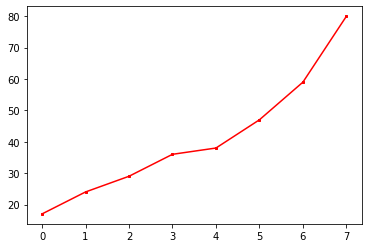

In [457]:
import matplotlib.pyplot as plt
#for epoch in range(total_epoch):  
#x = [5, 10, 15, 20, 25, 30, 35, 40]
x = [epoch for epoch in range(8)]
y = [17, 24, 29, 36, 38, 47, 59, 80]
plt.plot(x,y,'rs-',markersize =2) # 那个点
plt.show()
# precision: TP/(TP+FP)
#recall

In [367]:
predicted2

tensor([0, 0, 0,  ..., 0, 0, 0])

In [368]:
predicted

tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,

In [369]:
label_train_encoded

array([0, 0, 0, ..., 1, 1, 1])

In [371]:
#如果loss曲线表现出线性（下降缓慢）表明学习率太低

In [ ]:
'''
问题：多分类网络加了两层全连接后最后输出1类，计算loss时报错Target N is out of bounds

其中的N是正在处理的数据输入的标签，即第几类，是一个 [0, 类数-1] 的整数，最后输出1类与输入的target不符就会报错

'''

In [372]:
#LSTM-BI
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Bi_LSTM_Model(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Model, self).__init__()
        #self.emb = nn.Embedding(vocab_size, emb_dim)
        # Initialize the Embedding layer with the lookup table we created 
        #self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        #self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        #x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n,c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z


# Move the model to GPU
model = Bi_LSTM_Model().to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


#train
for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sent_encoded_train.shape[0],batch_size):
        input_batch = sent_encoded_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])] #256,22,101
        target_batch = label_train[ind:min(ind+batch_size, sent_encoded_train.shape[0])]  #256
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)  #256,22,101
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device) #256

        model.train()
        optimizer.zero_grad()
        outputs = model(input_batch_torch)   #13,512,25 #256，22，101    #256 2
        loss = criterion(outputs, target_batch_torch) #256 2    256 out,y
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    predicted = torch.argmax(outputs, 1)  # 输出值为元祖获取第二个tensor        
    acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
    print('Epoch: %d, train loss: %.5f, train_acc:%.2f'%(epoch + 1, train_loss, acc))

print('Finished Training')


## Prediction

model.eval()
outputs2 = model(torch.from_numpy(sent_encoded_test).float().to(device)) 
predicted2 = torch.argmax(outputs2, 1)

# classification_report builds a text report showing the main classification metrics
# The returned report includes the 'weighted avg f1' we want (refer to the sample output)
# More details can be found from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report

#target_names = ['class 0', 'class 1', 'class 2'] #
print(classification_report(label_test, predicted2.cpu().numpy(),digits=4))
#是改变了batch


Epoch: 1, train loss: 8.99311, train_acc:0.00
Epoch: 2, train loss: 6.80813, train_acc:0.00
Epoch: 3, train loss: 6.88997, train_acc:0.00
Epoch: 4, train loss: 6.93522, train_acc:0.00
Epoch: 5, train loss: 6.95755, train_acc:0.00
Epoch: 6, train loss: 6.96665, train_acc:0.02
Epoch: 7, train loss: 6.96877, train_acc:0.06
Epoch: 8, train loss: 6.96772, train_acc:0.09
Epoch: 9, train loss: 6.96549, train_acc:0.12
Epoch: 10, train loss: 6.96298, train_acc:0.17
Epoch: 11, train loss: 6.96052, train_acc:0.22
Epoch: 12, train loss: 6.95824, train_acc:0.29
Epoch: 13, train loss: 6.95614, train_acc:0.33
Epoch: 14, train loss: 6.95418, train_acc:0.34
Epoch: 15, train loss: 6.95235, train_acc:0.35
Epoch: 16, train loss: 6.95061, train_acc:0.38
Epoch: 17, train loss: 6.94896, train_acc:0.39
Epoch: 18, train loss: 6.94736, train_acc:0.39
Epoch: 19, train loss: 6.94582, train_acc:0.40
Epoch: 20, train loss: 6.94430, train_acc:0.40
Finished Training
              precision    recall  f1-score   suppo

In [ ]:
# 获取学习率lr_find()
#一般来说，越大的batch-size使用越大的学习率。
'''
我们经常使用的是5-折(5-fold)交叉验证，将训练集分成5份，随机挑一份做验证集其余为训练集，循环5次，这种比较常见计算量也不是很大。还有一种叫做leave-one-out cross validation留一交叉验证，这种交叉验证就是n-折交叉，n表示数据集的容量，这种方法只适合数据量比较小的情况，计算量非常大的情况很少用到这种方法
'''

#更改了学习率和batch_size 它好像就可以了。


#各种解释

In [ ]:
# classification_report
'''
精确度， 召回率，F1

y_true : 目标值。 #label_test 
y_pred: 估计值    #predicted.cpu().numpy()
labels: array , shape=[n_labels]  标签索引的可选列表
target_names: 标签相同顺序。 
sample_weight: shape = [n_samples]  可选项， 样本券种。 
digits 浮点数位数。   #digits=4
看法
右边support列为每个标签的出现次数
avg / total行为各列的均值（support列为总和）． 

0 消极1积极
'''
'''
当一个搜索引擎返回30个页面时，只有20页是相关的，而没有返回40个额外的相关页面，
其精度为20/30 = 2/3，而其召回率为20/60 = 1/3。
在这种情况下，精确度是“搜索结果有多大用处”，而召回是“结果如何完整”。
 F1
值

 F1
值是精确度和召回率的调和平均值：

 2F1=1P+1R

 F1=2P×RP+R

精确度和召回率都高时， F1
值也会高． F1
值在1时达到最佳值（完美的精确度和召回率），最差为0．在二元分类中， F1
值是测试准确度的量度。


https://blog.csdn.net/akadiao/article/details/78788864?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522161924744416780261967427%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=161924744416780261967427&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-2-78788864.first_rank_v2_pc_rank_v29&utm_term=classification+report怎么看
'''

'''
  def classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
  
    事实上从字面上看accuray和f1一样都可以作为一个指标评判整个模型，
但是accruracy存在一个bug，当数据严重不均衡时，       
 accuracy不起作用，比如我们看X光片，
 真实数据是：99%都是无病的，只有1%是有病的，
 假设一个分类器只要给它一张X 光片，它就判定是无病的，那么它的准确率也有99%，
 乍看很高，然而这个模型根本就不work


==
4.support

    支持度，是指原始的真实数据中属于该类的个数
    ===
 只有当P和R都很高的时候，F1才会高，所以称为调和平均数，F1的取值范围是0到1

 召回率是覆盖面的度量，也就是被分类器正确分为正例的个数(TP)占原始数据中全部正例

  精确率是精确性的指标，表示被分类器正确分为正例的个数(TP)占被分类器分为正例的样本




    要想知道这些数据是怎么算出来的，要先了解一下几个常见的模型评价术语，现在假设我们的分类目标只有两类，计为正例或阳例（positive）和负例或阴例（negtive）分别是：

　　(1)True positives(TP):  被正确地划分为正例的个数，即实际为正例且被分类器划分为正例的实例数（样本数）；

　　(2)False positives(FP): 被错误地划分为正例的个数，即实际为负例但被分类器划分为正例的实例数；

　　(3)False negatives(FN):被错误地划分为负例的个数，即实际为正例但被分类器划分为负例的实例数；

　　(4)True negatives(TN): 被正确地划分为负例的个数，即实际为负例且被分类器划分为负例的实例数。

  '''
  '''
start = time.time()  
xxx
end =time.time()
print(end-start)

'''

#evaluation

#第一个part

In [373]:
#评估类比测试集。 analogy 类比
!git clone https://github.com/stanfordnlp/GloVe.git

fatal: destination path 'GloVe' already exists and is not an empty directory.


In [374]:
#我的
wv_cbow_model.save("cbow.model")
#训练 ； 存 取；训练。
cbow = Word2Vec.load("./cbow.model")
cbow.train(sentences= train_stem + test_stem ,total_examples=wv_cbow_model.corpus_count, epochs=cbow.iter)
#举个例子，已经训练好的word2vec词表有[“我”,“爱”,“你”]三个词，给定一个新语料[“我”,“喜”,“欢”,“你”]，新语料只会调整原有词中的“我”“你”的词向量表示，而不会将“喜”“欢”添加到词库中。


#可以把训练完的存成文本。
wv_cbow_model.wv.save_word2vec_format('cbow.txt',binary=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [375]:
vectors_file="/content/cbow.txt"

In [376]:
with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [x for x in vals[1:]]


In [377]:
vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter  
vocab = {w: idx for idx, w in enumerate(vocab_words)} #每个单词对应个index
ivocab = {idx: w for idx, w in enumerate(vocab_words)}  #每个index对应一个单词

Vocab size:  4325


In [378]:
W[vocab[word], :] = v

In [379]:
word

'neenkin'

In [380]:
# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])  #100
W = np.zeros((vocab_size, vector_dim))    #4325.100
for word, v in vectors.items():
    if word == '<unk>' or word == '':
        continue
    
    W[vocab[word], :] = v   #100 102

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [381]:

def evaluate_vectors(W, vocab, prefix='./content/GloVe/eval/question-data/'):#/content/GloVe/eval/question-data
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions  计算正确的语义问题
    correct_syn = 0; # count correct syntactic questions 计算正确的句法问题
    correct_tot = 0 # count correct questions   计算正确的问题
    count_sem = 0; # count all semantic questions 计算所有语义问题
    count_syn = 0; # count all syntactic questions  计算所有语法问题
    count_tot = 0 # count all questions   计算所有问题  
    full_count = 0 # count all questions, including those with unknown words    计算所有问题包括不知道n个单词的问题

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1) #216
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

    

In [382]:
#全是0可能不是模型的问题，可能是我的数据集太小了，需要不断的用w2v去训练。

In [383]:
correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')#/content/GloVe/eval/question-data
print('Questions seen/total: %.2f%% (%d/%d)' %    #看到的问题
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %  #语义准确度
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' % #语法准确度
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))
  #总准确度

capital-common-countries.txt:
ACCURACY TOP1: 0.00% (0/6)
capital-world.txt:
ACCURACY TOP1: 0.00% (0/3)
ERROR: no lines of vocab kept for currency.txt !
Example missing line: ['algeria', 'dinar', 'angola', 'kwanza']
ERROR: no lines of vocab kept for city-in-state.txt !
Example missing line: ['chicago', 'illinois', 'houston', 'texas']
family.txt:
ACCURACY TOP1: 0.00% (0/56)
ERROR: no lines of vocab kept for gram1-adjective-to-adverb.txt !
Example missing line: ['amazing', 'amazingly', 'apparent', 'apparently']
ERROR: no lines of vocab kept for gram2-opposite.txt !
Example missing line: ['acceptable', 'unacceptable', 'aware', 'unaware']
gram3-comparative.txt:
ACCURACY TOP1: 0.00% (0/90)
gram4-superlative.txt:
ACCURACY TOP1: 0.00% (0/30)
ERROR: no lines of vocab kept for gram5-present-participle.txt !
Example missing line: ['code', 'coding', 'dance', 'dancing']
gram6-nationality-adjective.txt:
ACCURACY TOP1: 0.00% (0/29)
ERROR: no lines of vocab kept for gram7-past-tense.txt !
Example miss

**第三个part**

In [417]:
#　(1)True positives(TP):  被正确地划分为正例的个数，即实际为正例且被分类器划分为正例的实例数（样本数）；

#　(2)False positives(FP): 被错误地划分为正例的个数，即实际为负例但被分类器划分为正例的实例数；

#　(3)False negatives(FN):被错误地划分为负例的个数，即实际为正例但被分类器划分为负例的实例数；

#　　(4)True negatives(TN): 被正确地划分为负例的个数，即实际为负例且被分类器划分为负例的实例数。
'''
1把这几个都搞出来。
然后根据那个比较什么的搞出F1


SyntaxError: ignored